# Exercise: Hurricane Michael

Using the geopandas library, turn the latitude and longitude columns into a geographical Point data type then make a geodataframe. Plot the path of Hurricane Michael onto the US map in the GeoJSON file.


Tips

After loading the US_states(5m).json file as a geodataframe, use the following code to create a geodataframe that only contains the contiguous United States (48 states):
map48 = map_df.loc[map_df['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico']) == False]
The longitude column data should be turned into negative values(data source listed longitude direction instead of positive/negative). Use the following code to make the data correct:
michaeldf['Long'] = 0 - michaeldf['Long']
Feel free to add any additional features to your plot (marker shape, marker color, etc.)

In [1]:
import pandas as pd
import geopandas as gpd #used for transforming geolocation data
import matplotlib.pyplot as plt

from datetime import datetime  #to convert data to datetime that does not fall within the pandas.to_datetime function timeframe
from shapely.geometry import Point  #transform latitude/longitude to geo-coordinate data
from geopandas.tools import geocode #get the latitude/longitude for a given address
from geopandas.tools import reverse_geocode  #get the address for a location using latitude/longitude

import time
import json
import geopy
%matplotlib inline

# Geocoding and Reverse Geocoding

#Geocode a Dataframe column

In [2]:
#dataset of addresses in Finland
#location = "hurricaneMichael.csv"

#load data into dataframe
#seperator between values in file is a semicolon
hurmichaeldf = pd.read_csv('hurricaneMichael.csv')
hurmichaeldf.head()


,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster
0,1,10/06/2018 17:00,18.0,86.6,30,1006,NW at 6 MPH (325 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 16:50,Beven
1,1A,10/06/2018 20:00,18.3,86.6,30,1004,N at 6 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 19:32,Avila
2,2,10/06/2018 23:00,18.8,86.6,30,1004,N at 7 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 22:38,Avila
3,2A,10/07/2018 02:00,18.4,87.1,35,1004,NW at 5 MPH (320 deg),Potential Tropical Cyclone,Fourteen,10/07/2018 01:38,Berg
4,3,10/07/2018 05:00,18.6,86.9,35,1004,NNW at 3 MPH (340 deg),Tropical Depression,FOURTEEN,10/07/2018 04:53,Berg


In [3]:
hurmichaeldf['Long'] = 0 - hurmichaeldf['Long']

In [4]:
hurmichaeldf.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster
0,1,10/06/2018 17:00,18.0,-86.6,30,1006,NW at 6 MPH (325 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 16:50,Beven
1,1A,10/06/2018 20:00,18.3,-86.6,30,1004,N at 6 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 19:32,Avila
2,2,10/06/2018 23:00,18.8,-86.6,30,1004,N at 7 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 22:38,Avila
3,2A,10/07/2018 02:00,18.4,-87.1,35,1004,NW at 5 MPH (320 deg),Potential Tropical Cyclone,Fourteen,10/07/2018 01:38,Berg
4,3,10/07/2018 05:00,18.6,-86.9,35,1004,NNW at 3 MPH (340 deg),Tropical Depression,FOURTEEN,10/07/2018 04:53,Berg


In [5]:
hurmichaeldf['address'] = list(hurmichaeldf[['Long', 'Lat']].values)

In [6]:
hurmichaeldf.dtypes

AdvisoryNumber     object
Date               object
Lat               float64
Long              float64
Wind                int64
Pres                int64
Movement           object
Type               object
Name               object
Received           object
Forecaster         object
address            object
dtype: object

In [7]:
hurmichaeldf['address'].dtypes

dtype('O')

In [8]:
type(hurmichaeldf['address'])

pandas.core.series.Series

In [9]:
#only dataframe with non-null year column values
hurmichaeldf = hurmichaeldf.loc[hurmichaeldf['Date'].notnull()]

#change year column into a string
#need to use string type for getYear function below
hurmichaeldf['Date'] = hurmichaeldf['Date'].astype(str)

In [10]:
#function to split apart the date from the timestamp
def getYear(col):
    #get YYYY-MM-DD value
    date = col.split("T")
    
    #extract year from date
    dt = datetime.strptime(date, '%Y-%m-%d')
    return dt.year

In [11]:
#see columns with null values 959
hurmichaeldf.count()

AdvisoryNumber    45
Date              45
Lat               45
Long              45
Wind              45
Pres              45
Movement          45
Type              45
Name              45
Received          45
Forecaster        45
address           45
dtype: int64

In [12]:
#see new coordinates column
hurmichaeldf.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster,address
0,1,10/06/2018 17:00,18.0,-86.6,30,1006,NW at 6 MPH (325 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 16:50,Beven,"[-86.6, 18.0]"
1,1A,10/06/2018 20:00,18.3,-86.6,30,1004,N at 6 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 19:32,Avila,"[-86.6, 18.3]"
2,2,10/06/2018 23:00,18.8,-86.6,30,1004,N at 7 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 22:38,Avila,"[-86.6, 18.8]"
3,2A,10/07/2018 02:00,18.4,-87.1,35,1004,NW at 5 MPH (320 deg),Potential Tropical Cyclone,Fourteen,10/07/2018 01:38,Berg,"[-87.1, 18.4]"
4,3,10/07/2018 05:00,18.6,-86.9,35,1004,NNW at 3 MPH (340 deg),Tropical Depression,FOURTEEN,10/07/2018 04:53,Berg,"[-86.9, 18.6]"


In [13]:
#convert the coordinates to a geolocation type
hurmichaeldf['address'] = hurmichaeldf['address'].apply(Point)

In [14]:
#list values in coordinates column is classified as object type
hurmichaeldf['address'].dtypes

dtype('O')

In [15]:
#convert the coordinates to a geolocation type
hurmichaeldf['address'] = hurmichaeldf['address'].apply(Point)

In [16]:
#coordinates column now has POINT next to each coordinate pair value
hurmichaeldf.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster,address
0,1,10/06/2018 17:00,18.0,-86.6,30,1006,NW at 6 MPH (325 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 16:50,Beven,POINT (-86.59999999999999 18)
1,1A,10/06/2018 20:00,18.3,-86.6,30,1004,N at 6 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 19:32,Avila,POINT (-86.59999999999999 18.3)
2,2,10/06/2018 23:00,18.8,-86.6,30,1004,N at 7 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 22:38,Avila,POINT (-86.59999999999999 18.8)
3,2A,10/07/2018 02:00,18.4,-87.1,35,1004,NW at 5 MPH (320 deg),Potential Tropical Cyclone,Fourteen,10/07/2018 01:38,Berg,POINT (-87.09999999999999 18.4)
4,3,10/07/2018 05:00,18.6,-86.9,35,1004,NNW at 3 MPH (340 deg),Tropical Depression,FOURTEEN,10/07/2018 04:53,Berg,POINT (-86.90000000000001 18.6)


In [17]:
hurmichaeldf['Date'] = pd.to_datetime(hurmichaeldf['Date'], errors='coerce')


In [18]:
#create a geolocation dataframe type using the coordinates column as the geolocation data
geo_hurricane = gpd.GeoDataFrame(hurmichaeldf, geometry='address')

In [19]:

#geo-dataframe looks the same as regular dataframe
hurmichaeldf.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster,address
0,1,2018-10-06 17:00:00,18.0,-86.6,30,1006,NW at 6 MPH (325 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 16:50,Beven,POINT (-86.59999999999999 18)
1,1A,2018-10-06 20:00:00,18.3,-86.6,30,1004,N at 6 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 19:32,Avila,POINT (-86.59999999999999 18.3)
2,2,2018-10-06 23:00:00,18.8,-86.6,30,1004,N at 7 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 22:38,Avila,POINT (-86.59999999999999 18.8)
3,2A,2018-10-07 02:00:00,18.4,-87.1,35,1004,NW at 5 MPH (320 deg),Potential Tropical Cyclone,Fourteen,10/07/2018 01:38,Berg,POINT (-87.09999999999999 18.4)
4,3,2018-10-07 05:00:00,18.6,-86.9,35,1004,NNW at 3 MPH (340 deg),Tropical Depression,FOURTEEN,10/07/2018 04:53,Berg,POINT (-86.90000000000001 18.6)


In [20]:
#verify coordinates column is geolocation data type
type(geo_hurricane['address'])

geopandas.geoseries.GeoSeries

In [21]:
#create a geolocation dataframe type using the coordinates column as the geolocation data
geo_meteor = gpd.GeoDataFrame(hurmichaeldf, geometry='address')

In [22]:
#geo-dataframe looks the same as regular dataframe
geo_meteor.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster,address
0,1,2018-10-06 17:00:00,18.0,-86.6,30,1006,NW at 6 MPH (325 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 16:50,Beven,POINT (-86.59999999999999 18)
1,1A,2018-10-06 20:00:00,18.3,-86.6,30,1004,N at 6 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 19:32,Avila,POINT (-86.59999999999999 18.3)
2,2,2018-10-06 23:00:00,18.8,-86.6,30,1004,N at 7 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/06/2018 22:38,Avila,POINT (-86.59999999999999 18.8)
3,2A,2018-10-07 02:00:00,18.4,-87.1,35,1004,NW at 5 MPH (320 deg),Potential Tropical Cyclone,Fourteen,10/07/2018 01:38,Berg,POINT (-87.09999999999999 18.4)
4,3,2018-10-07 05:00:00,18.6,-86.9,35,1004,NNW at 3 MPH (340 deg),Tropical Depression,FOURTEEN,10/07/2018 04:53,Berg,POINT (-86.90000000000001 18.6)


In [23]:
#import file that contains a world map shape polygons
#will use to plot the coordinates of meteorite landings
filepath = "US_states.json"

#data contains polygon shape coordinates for different map body types (continents, etc.)
map_df = gpd.read_file(filepath)
map_df.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"(POLYGON ((-88.124658 30.28364, -88.0868119999..."
1,0400000US02,02,Alaska,,570640.950,"(POLYGON ((-166.10574 53.988606, -166.075283 5..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.538593 37.000674, -112.534545 3..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.042964 33.019219, -94.043036 33...."
4,0400000US06,06,California,,155779.220,"(POLYGON ((-122.421439 37.869969, -122.421341 ..."


In [24]:
map48 = map_df.loc[map_df['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico']) == False]

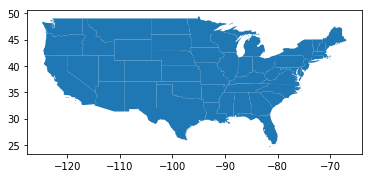

In [25]:
map48.plot()

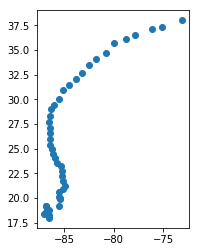

In [26]:
geo_hurricane.plot()

Text(0.5, 1.0, 'Path of Hurricane Michael')

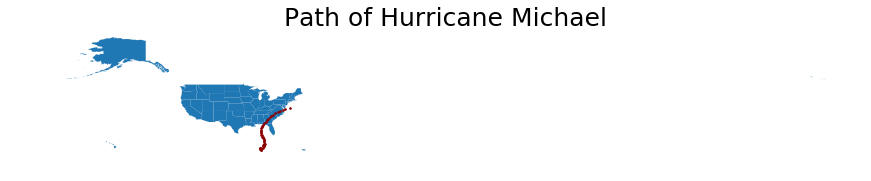

In [27]:
#plot coordinates on top of map graph

#this is to set the size of the borders
fig, ax = plt.subplots(1, figsize=(15,20))

#this is the map
basemap = map_df.plot(ax=ax)

#plot coordinates on top of map graph
geo_hurricane.plot(ax=basemap, color='darkred', marker=".", markersize=10)

#take off axis numbers
ax.axis('off')

#put title on map
ax.set_title("Path of Hurricane Michael", fontsize=25, fontweight=3)

Text(0.5, 1.0, 'Path of Hurricane Michael')

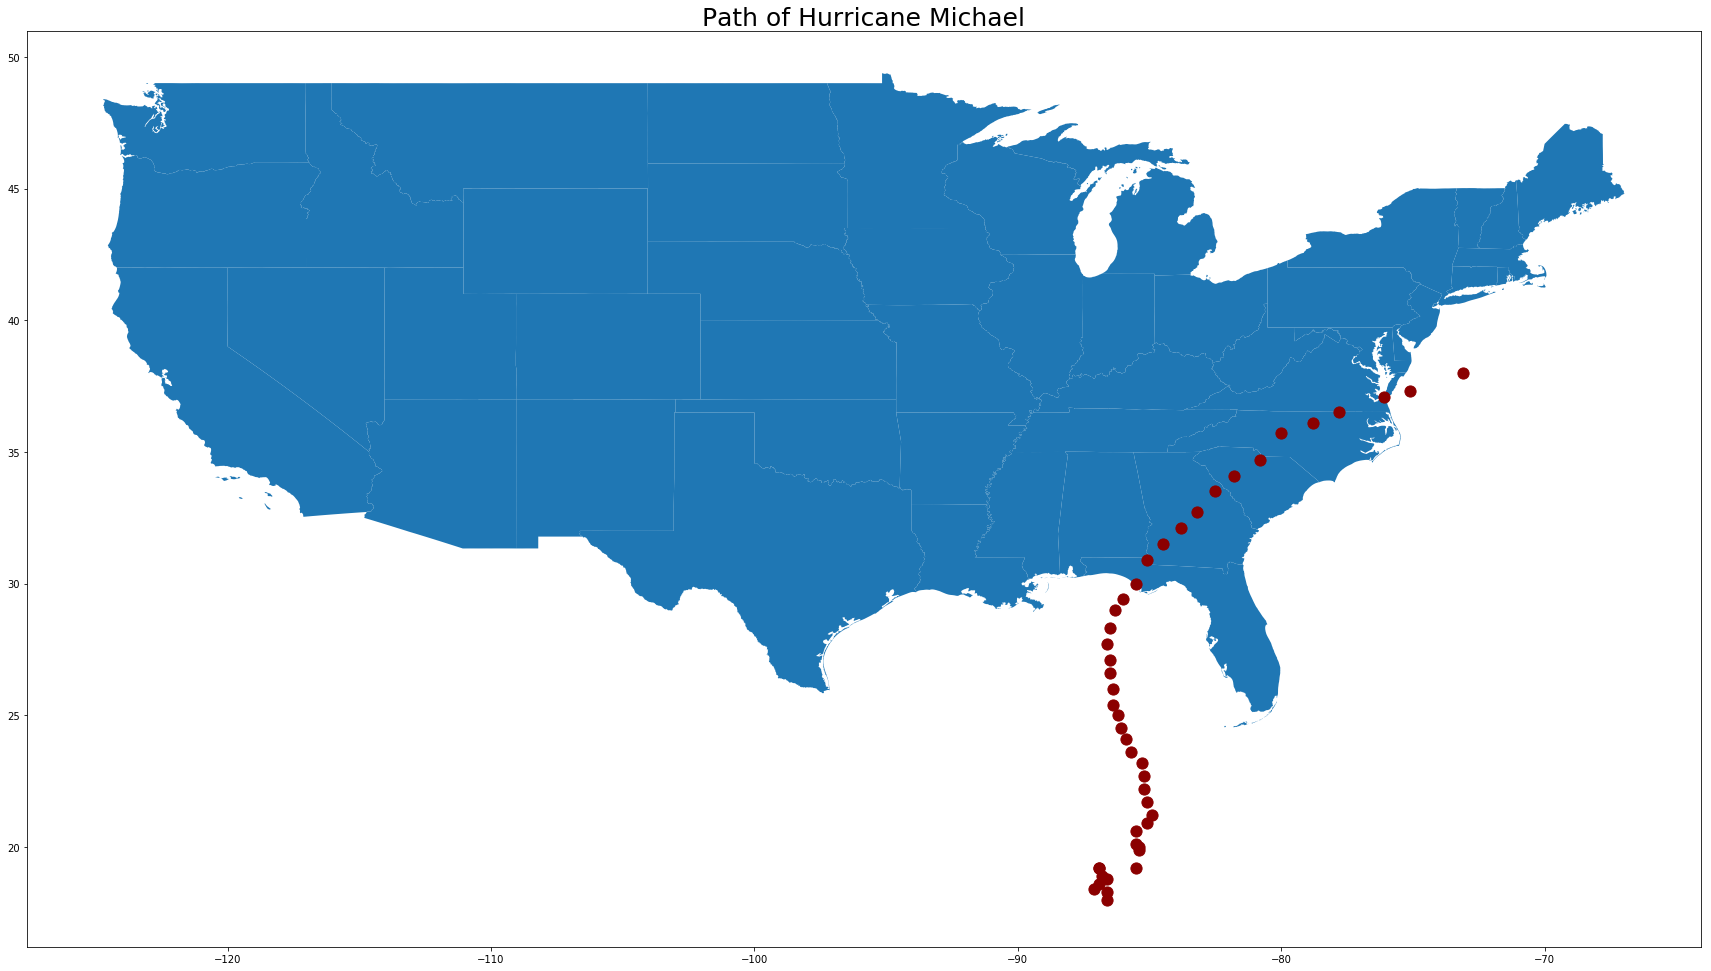

In [28]:
fig, ax = plt.subplots(1, figsize=(30,20))

#this is the map
basemap = map_df[map_df['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico']) == False].plot(ax=ax, figsize=(15,10));

#plot coordinates on top of map graph
geo_hurricane.plot(ax=basemap, color='darkred', marker=".", markersize=500)

#put title on map
ax.set_title("Path of Hurricane Michael", fontsize=25, fontweight=3)